# Chatbot with Profile Schema 

## Review

We introduced the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We built a simple chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

It saved long-term [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory) (facts about the user) ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories), as the user is chatting with it.

## Goals

Our chatbot saved memories as a string. 
##### In practice, we often want memories to have a structure. 
 
- For example, memories can be a [single, continuously updated schema]((https://langchain-ai.github.io/langgraph/concepts/memory/#profile)). **[PROFILE]**
 
#### In our case, we want this to be a single user profile.
 
- We'll extend our chatbot to save semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile). 

We'll also introduce **a library, [Trustcall](https://github.com/hinthornw/trustcall), to update this schema with new information.**

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [2]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Defining a user profile schema

##### Python has many different types for [structured data](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition), such as TypedDict, Dictionaries, JSON, and [Pydantic](https://docs.pydantic.dev/latest/). 

Let's start by using TypedDict to define a user profile schema.

In [3]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

## Saving a schema to the store

#### The [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) accepts any Python dictionary as the `value`. 

In [4]:
# TypedDict instance
user_profile: UserProfile = {
    "user_name": "Lance",
    "interests": ["biking", "technology", "coffee"]
}
user_profile

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

#### We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save the TypedDict to the store.

In [5]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

#### We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by namespace.

In [6]:
# Search by namespace
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}, 'created_at': '2025-09-27T22:55:03.440870+00:00', 'updated_at': '2025-09-27T22:55:03.440872+00:00', 'score': None}


#### We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve a specific object by namespace and key.

In [7]:
# Get the memory by namespace and key ("user_profile")
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

## Chatbot with profile schema

Now we know how to **specify a schema for the memories and save it to the store**.

#### Now, how do we actually *create* memories with this particular schema?

- In our chatbot, we [want to create memories from a user chat](https://langchain-ai.github.io/langgraph/concepts/memory/#profile). 

##### This is where the concept of [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) is useful. 

### LangChain's [chat model](https://python.langchain.com/docs/concepts/chat_models/) interface has a **[`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) method to enforce structured output.**

> This is useful when we want to enforce that the output conforms to a schema, and it parses the output for us.

In [8]:
_set_env("OPENAI_API_KEY")

Let's pass the `UserProfile` schema we created to the `with_structured_output` method.

We can then invoke the chat model with a list of [messages](https://python.langchain.com/docs/concepts/messages/) and get a structured output that conforms to our schema.

In [9]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Bind schema to model -> structured output
model_with_structure = model.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])
structured_output

{'user_name': 'Lance', 'interests': ['biking']}

##### Now, let's use this with our chatbot.

- This only requires minor changes to the `write_memory` function. 

- We use `model_with_structure`, as defined above, to produce a profile that matches our schema. 

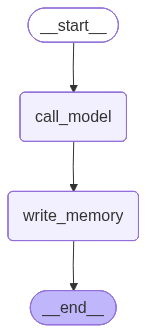

In [10]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    # standard model, no structured output
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    # model_with_structure, model with structured output
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer and memory store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [11]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.
================================== Ai Message ==================================

Hi Lance! It's great to meet you! Biking around San Francisco sounds like a lot of fun, especially with all the beautiful views. Do you have any favorite bakeries in the area?


Let's check the memory in the store. 

We can see that the memory is a dictionary that matches our schema.

In [12]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Lance', 'interests': ['biking', 'bakeries', 'San Francisco']}

## When can this fail?

[`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) is very useful, **but what happens if we're working with a more complex schema?** 

##### [Here's](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) an example of a more complex schema, which we'll test below. 

#### This is a [Pydantic](https://docs.pydantic.dev/latest/) model that describes a user's preferences for communication and trust fall.

In [ ]:
# Complex pydantic model with a bunch of nesting 
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

#### Now, let's try extraction of this schema using the `with_structured_output` method.

In [ ]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    print(model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>"""))
except ValidationError as e:
    print(e)

#### well i did not get any errors...maybe pydantic already solved the issue?
#### Still, this took 5 seconds....too much time

""" OUTPUT
pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(
    telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='Daredevil', 
    sentence_preference_revealed='Send it by your fastest carrier pigeon.')], 
    favorite_telegram_operators=None, 
    preferred_telegram_paper=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Perfect!')]), 
    morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', 
    sentence_preference_revealed='I love using a straight key.')], 
    favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, 
    semaphore_skill_level=None)), 
    trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher fall', sentence_preference_revealed="I'm ready for a higher fall.")], 
    trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_revealed='I prefer the diamond formation for catching.')]))
"""

pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Send it by your fastest carrier pigeon.')], favorite_telegram_operators=None, preferred_telegram_paper=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Perfect!')]), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', sentence_preference_revealed='I love using a straight key.')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher fall', sentence_preference_revealed="I'm ready for a higher fall.")], trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_revealed='I prefer the diamond formation for catching.')]))


#### Error presented in the video
- The video showed a validation error here, because at that time even with a bigger model like gpt-4o, it was still prone to failure.
- It was stated that the with_structured_output method was not always reliable as schemas get more complex.
- Then, there was a motivation to use Trustcall open source lib to manage that.

#### If we naively extract more complex schemas, even using high capacity model like `gpt-4o`, it is prone to failure.


## Trustcall for creating and updating profile schemas

As we can see, working with schemas can be tricky.

#### Complex schemas can be difficult to extract. 

> In addition, updating even simple schemas can pose challenges.

Consider our above chatbot. 

#### We regenerated the profile schema *FROM SCRATCH* each time we chose to save a new memory.

##### This is inefficient, potentially wasting model tokens if the schema contains a lot of information to re-generate each time.

##### Worse, we may loose information when regenerating the profile from scratch.

### Addressing these problems is the motivation for [TrustCall](https://github.com/hinthornw/trustcall)!

- This is an open-source library for updating JSON schemas developed by one [Will Fu-Hinthorn](https://github.com/hinthornw) on the LangChain team.

- It's motivated by exactly these challenges while working on memory.

##### Let's first show simple usage of extraction with TrustCall on this list of [messages](https://python.langchain.com/docs/concepts/messages/).


In [17]:
# Mock Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="I really like biking around San Francisco.")]

##### We use `create_extractor`, passing in the `model`, as well as our `schema` **as a [tool](https://python.langchain.com/docs/concepts/tools/).**

With TrustCall, can supply supply the schema in various ways. 

For example, we can pass a **JSON object / Python dictionary or Pydantic model**.

Under the hood, **TrustCall uses [tool calling](https://python.langchain.com/docs/concepts/tool_calling/) to produce [structured output](https://python.langchain.com/docs/concepts/structured_outputs/) from an input list of [messages](https://python.langchain.com/docs/concepts/messages/)**.

#### To force Trustcall to produce [structured output](https://python.langchain.com/docs/concepts/structured_outputs/), **we can include the schema name in the `tool_choice` argument.**

Let's invoke the extractor with  the first conversation.

In [18]:
from trustcall import create_extractor

# Schema with pydantic
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

# Initialize the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile], # passing the schema as a tool
    tool_choice="UserProfile" # forcing the tool to produce structured output by passing the schema name 
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r5Taa84OMP9dqIifnnVuKbEN', 'function': {'arguments': '{"user_name":"Lance","interests":["biking","San Francisco"]}', 'name': 'UserProfile'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 128, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CKizt01Deu8aDwM3Psr7n8hOSIesD', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--cfd460b1-8905-46fa-b8cb-d5a6fb75fc47-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': 'Lance', 'interests': ['biking', 'San Francisco']}, 'id': 'call_r5Taa84OMP9dqIifnnVuKbEN', 'type': 'tool_call'}], usage_m

#### When we invoke the extractor, we get a few things:

* `messages`: The list of `AIMessages` that contain the tool calls. 
* **`responses`: The resulting parsed tool calls that match our schema.**
* `response_metadata`: Applicable if updating existing tool calls. It says which of the responses correspond to which of the existing objects.


In [19]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_r5Taa84OMP9dqIifnnVuKbEN)
 Call ID: call_r5Taa84OMP9dqIifnnVuKbEN
  Args:
    user_name: Lance
    interests: ['biking', 'San Francisco']


In [20]:
schema = result["responses"]
schema

[UserProfile(user_name='Lance', interests=['biking', 'San Francisco'])]

In [21]:
schema[0].model_dump()

{'user_name': 'Lance', 'interests': ['biking', 'San Francisco']}

In [24]:
result["response_metadata"]

[{'id': 'call_ePpGPltZvWIU6ie4j8H4dCuv'}]

##### Let's see how we can use it to *update* the profile.

- For updating, TrustCall takes a **set of messages** as well as the **existing schema**. 

- The central idea is that it prompts the model to produce a [JSON Patch](https://jsonpatch.com/) to update only the relevant parts of the schema.

- **This is less error-prone than naively overwriting the entire schema.**

#### It's also more efficient since the model only needs to generate the parts of the schema that have changed.

- We can **save the existing schema as a dict**.

- We can use `model_dump()` to **serialize a Pydantic model instance into a dict.** 

- We pass it to the `"existing"` argument along with the schema name, `UserProfile`. 

In [25]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Lance."), 
                        AIMessage(content="Nice to meet you, Lance."), 
                        HumanMessage(content="I really like biking around San Francisco."),
                        AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})  

In [26]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_mfbayZtIyghcwhPQ3jKg0aM3)
 Call ID: call_mfbayZtIyghcwhPQ3jKg0aM3
  Args:
    user_name: Lance
    interests: ['biking', 'bakeries', 'San Francisco']


In [27]:
result["response_metadata"]

[{'id': 'call_mfbayZtIyghcwhPQ3jKg0aM3'}]

In [28]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Lance', 'interests': ['biking', 'bakeries', 'San Francisco']}

LangSmith trace:

https://smith.langchain.com/public/229eae22-1edb-44c6-93e6-489124a43968/r

#### Now, let's also test Trustcall on the [challenging schema](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) that we saw earlier.

In [31]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"]

### Well this took 16 seconds....


[TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='morse_code', sentence_preference_revealed='Morse code')], favorite_telegram_operators=None, preferred_telegram_paper=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Daredevil paper')]), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', sentence_preference_revealed='Straight key')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher', sentence_preference_revealed='Higher fall')], trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_revealed='Diamond formation')])))]

In [30]:
""" OUTPUT
[TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(
    communication_preferences=CommunicationPreferences(
        telegram=TelegramPreferences(preferred_encoding=[OutputFormat(
            preference='morse', sentence_preference_revealed='Morse code')], 
            favorite_telegram_operators=None, preferred_telegram_paper=None), 
            morse_code=MorseCode(preferred_key_type=[OutputFormat(
                preference='straight key', sentence_preference_revealed='I love using a straight key')], 
                favorite_morse_abbreviations=None), 
                semaphore=Semaphore(preferred_flag_color=None, 
                semaphore_skill_level=None)), 
                trust_fall_preferences=TrustFallPreferences(
                    preferred_fall_height=[OutputFormat(preference='higher', sentence_preference_revealed='I need a higher fall')], 
                    trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', 
                    sentence_preference_revealed='I prefer the diamond formation for catching')])))]
"""

" OUTPUT\n[TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(\n    communication_preferences=CommunicationPreferences(\n        telegram=TelegramPreferences(preferred_encoding=[OutputFormat(\n            preference='morse', sentence_preference_revealed='Morse code')], \n            favorite_telegram_operators=None, preferred_telegram_paper=None), \n            morse_code=MorseCode(preferred_key_type=[OutputFormat(\n                preference='straight key', sentence_preference_revealed='I love using a straight key')], \n                favorite_morse_abbreviations=None), \n                semaphore=Semaphore(preferred_flag_color=None, \n                semaphore_skill_level=None)), \n                trust_fall_preferences=TrustFallPreferences(\n                    preferred_fall_height=[OutputFormat(preference='higher', sentence_preference_revealed='I need a higher fall')], \n                    trust_level=None, preferred_catching_technique=[OutputFormat(prefe

Trace: 

https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r

For more examples, you can see an overview video [here](https://www.youtube.com/watch?v=-H4s0jQi-QY).

# Final Veredict: TrustCall vs. Pydantic

## Pydantic vs. TrustCall — Full Analysis 

### What was evaluated
- **Same inputs**, two extractors:
  1) **Pydantic-only** via `with_structured_output(Schema)`  
  2) **TrustCall** via `create_extractor(..., tools=[Schema], tool_choice="Schema")`
- **Two schema shapes**:
  - A **simple UserProfile** (flat lists + strings)
  - A **complex nested** schema (Telegram/Morse/Semaphore/TrustFall with multiple lists of `OutputFormat`)
- **What I checked**: correctness of structured output vs. your expected schema, runtime (wall-clock), and operational behavior (does it need repair/retries, is it robust to nesting, etc.)

---

### Results observed in the notebook
- **Pydantic-only** on complex schema:
  - **Output**: Valid, fully-populated nested object matching your `TelegramAndTrustFallPreferences` schema
  - **Time**: ~**5s**
  - **Errors**: **None** (no `ValidationError` thrown)
- **TrustCall** on the same complex schema:
  - **Output**: Also correct and complete
  - **Time**: ~**16s**
  - **Errors**: None, but **extra pass/overhead** (diff/repair mechanics)

> In short: for *extraction*, Pydantic-only returned correct structure **faster** than TrustCall in your environment.

---

### Why Pydantic-only is working now (vs. the video a year ago)
- Modern tool/structured-output paths have **improved adherence** to schemas (even with non-trivial nesting).
- You’re running **low temperature** with **deterministic prompts**, which strongly reduces JSON drift.
- The complex schema is nested but **not ambiguous** (few/no unions or discriminators) and fields are well-described.

---

### Pros & Cons (extraction stage)

**Pydantic-only (rewrite full object each time)**
- **Pros**
  - **Fast**: one model call, no repair pipeline (as seen: ~5s in your run)
  - **Simple**: fewer moving parts; end-to-end validation with Pydantic
  - **Easy to maintain**: fewer dependencies, straightforward prompt
- **Cons**
  - Regenerates **entire object** each time → potential token waste **on large objects**
  - **Rare** risk of a model **omitting previously known fields** (mitigated by low temp + clear field descriptions)
  - **Concurrency**: last-write-wins unless you add a merge policy

**TrustCall (JSON Patch / repair-first design)**
- **Pros**
  - Emits **diffs/patches** (token-efficient for updates; preserves untouched fields)
  - **Auto-repair** behavior can salvage malformed outputs or partial omissions
  - Better for **auditability** and **concurrent** updates (small, explainable changes)
- **Cons**
  - **Latency/cost overhead** (as seen: ~16s vs ~5s)
  - **Extra dependency and mental model** (patch apply, retries, reconciliation)

---

### Interpreting the difference in your runs
- On your extraction benchmarks, **Pydantic-only was correct and ~3× faster**.
- TrustCall did not add extra correctness value **in this context**; it only added **latency**.

---

### When TrustCall is *not* overkill (i.e., when it’s justified)
Use TrustCall if you face one or more of the following:
1. **Strict robustness** is required under **deep nesting / unions / discriminators / enums / regex constraints** and you see intermittent Pydantic validation failures.
2. You need **JSON Patch semantics** (small diffs) for **auditability**, **conflict-safe updates**, or **compliance** (who changed what, when).
3. You operate at **higher temperature** or with **smaller/less reliable models** that occasionally produce malformed/partial JSON.
4. You must **never drop** a request due to a `ValidationError` (auto-repair becomes operationally valuable).

If these do **not** apply, TrustCall’s extra pass is typically **unnecessary latency/cost**.

---

### Conclusion
- The experiments show that **Pydantic-only** extraction currently **meets correctness** and **wins on latency** (≈5s vs. ≈16s).  
- **Verdict**: Stick with **Pydantic-only** for these cases. TrustCall would be **overkill** unless you later hit one of the justified cases above (e.g., strict patching/auditing or recurring schema failures).


## Chatbot with profile schema updating (TrustCall)

Now, let's bring Trustcall into our chatbot to create *and update* a memory profile.

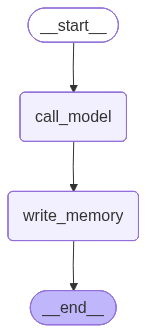

In [32]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# NOTE: TRUSTCALL !!!
# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool by passing the schema name
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# NOTE: TRUSTCALL !!!
# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # NOTE: TRUSTCALL !!!
    # This is using trustcall here instead of the model with `with_structured_output`
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [33]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi, Lance! It's nice to meet you. How can I assist you today?


In [34]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a great way to explore the city! San Francisco has some beautiful views and interesting neighborhoods to bike through. Do you have any favorite routes or spots you like to visit while biking?


In [35]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Lance',
  'user_location': 'San Francisco',
  'interests': ['biking']},
 'created_at': '2025-09-28T11:17:05.675112+00:00',
 'updated_at': '2025-09-28T11:17:05.675112+00:00'}

In [ ]:
# The user profile saved as a JSON object
existing_memory.value

{'user_name': 'Lance',
 'user_location': 'San Francisco',
 'interests': ['biking']}

In [37]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Biking to bakeries sounds like a delicious combination! San Francisco has some fantastic bakeries. Do you have any favorites, or are there any you’re looking to try?


Continue the conversation in a new thread.

In [ ]:
# Continue the conversation in a new thread.
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

# NOTE: I got an error here in the first execution, but it worked on the second try! So TrustCall is not perfect.

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Here are some great bakeries in San Francisco that you might enjoy:

1. **Tartine Bakery** - Renowned for its artisanal bread and pastries, Tartine is a must-visit. Their morning buns and croissants are particularly popular.

2. **B Patisserie** - This bakery specializes in French pastries, and their kouign-amann is a standout.

3. **Craftsman and Wolves** - Known for its creative pastries, the "rebel within," a savory muffin with a soft-cooked egg inside, is a unique treat.

4. **Miette** - A charming spot for classic French confections, Miette offers beautiful cakes and delightful sweets.

5. **Arizmendi Bakery** - A worker-owned cooperative, Arizmendi is famous for its sourdough bread and unique daily pastries.

These bakeries should provide plenty of delicious options for you to exp

Trace:

https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r

## Studio

![Screenshot 2024-10-30 at 11.26.31 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0437060f1754ea79908_Screenshot%202024-11-11%20at%207.48.53%E2%80%AFPM.png)

# Chatbot with profile schema updating (Pydantic-only, overwrite each turn)

In [40]:
# --- Chatbot with profile schema updating (Pydantic-only, overwrite each turn) ---

from IPython.display import Image, display
from typing import List

from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langchain_core.runnables.config import RunnableConfig

# Model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# ==== Schema (same shape as your TrustCall example) ====
class UserProfile(BaseModel):
    """Profile of a user"""
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: List[str] = Field(description="A list of the user's interests")

# Bind extractor (Pydantic-only structured output)
profile_extractor = model.with_structured_output(UserProfile)

# ==== Prompts ====
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

EXTRACTION_INSTRUCTION = """Create or update the user profile (JSON) using ONLY facts stated in the conversation."""

# ==== Nodes ====
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory JSON and use it to personalize the chatbot's response."""
    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    if existing_memory and existing_memory.value:
        mem = existing_memory.value
        formatted = (
            f"Name: {mem.get('user_name', 'Unknown')}\n"
            f"Location: {mem.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(mem.get('interests', []))}"
        )
    else:
        formatted = None

    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted)
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])
    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Extract profile from the latest conversation and OVERWRITE stored profile (no merge)."""
    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)

    # Extract a FULL profile directly via structured output
    extraction_prompt = [SystemMessage(content=EXTRACTION_INSTRUCTION)] + state["messages"]
    updated_profile: UserProfile = profile_extractor.invoke(extraction_prompt)

    # Overwrite the existing profile in the store
    store.put(namespace, "user_memory", updated_profile.model_dump())
    return {}

# ==== Graph ====
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

across_thread_memory = InMemoryStore()   # long-term (across-thread) memory
within_thread_memory = MemorySaver()     # short-term (within-thread) checkpoints

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

In [41]:
# ==== Example run parity with your TrustCall flow ====
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# 1) Turn 1
input_messages = [HumanMessage(content="Hi, my name is Lance")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance! It's nice to meet you. How can I assist you today?


In [42]:
# 2) Turn 2
input_messages = [HumanMessage(content="I like to bike around San Francisco")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a great way to explore the city! San Francisco has some beautiful views and interesting neighborhoods to bike through. Do you have any favorite routes or spots you like to visit while biking?


In [43]:
# Inspect stored profile (will be the LAST full overwrite)
ns = ("memory", "1")
print(across_thread_memory.get(ns, "user_memory").value)

{'user_name': 'Lance', 'user_location': 'San Francisco', 'interests': ['biking']}


In [44]:
# 3) Turn 3
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Biking to bakeries sounds like a delicious combination! San Francisco has some fantastic bakeries. Do you have any favorites, or are there any you’re looking to try?


In [45]:
# 4) New thread, same user (shows across-thread memory is read)
config2 = {"configurable": {"thread_id": "2", "user_id": "1"}}
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]
for chunk in graph.stream({"messages": input_messages}, config2, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you're in San Francisco and enjoy visiting bakeries, here are a few recommendations you might love:

1. **Tartine Bakery** - Famous for its artisanal bread and pastries, Tartine is a must-visit. Their morning buns and croissants are particularly popular.

2. **B Patisserie** - Known for its French pastries, B Patisserie offers a delightful selection, including their signature kouign-amann and various tarts.

3. **Craftsman and Wolves** - This bakery is known for its innovative pastries, including the famous "Rebel Within," a savory muffin with a soft-cooked egg inside.

4. **Miette** - A charming bakery with a focus on classic French confections, Miette is perfect for a sweet treat or a beautiful cake.

5. **Arizmendi Bakery** - A worker-owned cooperative, Arizmendi is known for i

## Comparing TrustCall and Pydantic-only in Langsmith (28/09/2025)
- Check the picture Trustcall(checked-boxes)_vs_Pydantic.png , the checked boxes are the TrustCall conversation interactions
- Pydantic was faster and used the same amount of tokens...